<a href="https://colab.research.google.com/github/moajjem04/PPG2IMP/blob/main/PPG2IMP_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

### Setting up Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing Libraries

In [ ]:
!pip install keras
!pip install scikit-learn

### Importing Modules

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import numpy.matlib

import scipy.io
from scipy.stats.stats import pearsonr
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
  

### Additional Imports

In [ ]:
%cd drive/MyDrive/PPG2ABP/
from helper_functions import *

/content/drive/MyDrive/PPG2ABP


# Data Loading

### Loading our dataset for PPG to IMP modelling

In [ ]:
data = scipy.io.loadmat('ppg2imp_data.mat')

### Getting PPG and IMP waveforms

In [ ]:
ppg = data['ppg']
imp = data['imp']

In [ ]:
print('ppg shape = ',ppg.shape)
print('imp shape = ',imp.shape)

ppg shape =  (3011, 1024)
imp shape =  (3011, 1024)


### Reshaping the data for transfer learning

In [ ]:
ppg = np.reshape(ppg,[ppg.shape[0],ppg.shape[1],1])
imp = np.reshape(imp,[imp.shape[0],imp.shape[1],1])
print('ppg shape = ',ppg.shape)
print('imp shape = ',imp.shape)

ppg shape =  (3011, 1024, 1)
imp shape =  (3011, 1024, 1)


### Processing the signals for the model

In [ ]:
ppg_max = np.amax(ppg, axis=None)
ppg_min = np.amin(ppg, axis=None)
imp_max = np.amax(imp, axis=None)
imp_min = np.amin(imp, axis=None)

In [ ]:
ppg_max

0.6494850913066782

In [ ]:
ppg_max = np.matlib.repmat(ppg_max, 3011, 1024)
ppg_max = np.reshape(ppg_max,[imp.shape[0],imp.shape[1],1])

ppg_min = np.matlib.repmat(ppg_min, 3011, 1024)
ppg_min = np.reshape(ppg_min,[imp.shape[0],imp.shape[1],1])

imp_max = np.matlib.repmat(imp_max, 3011, 1024)
imp_max = np.reshape(imp_max,[imp.shape[0],imp.shape[1],1])

imp_min = np.matlib.repmat(imp_min, 3011, 1024)
imp_min = np.reshape(imp_min,[imp.shape[0],imp.shape[1],1])

In [ ]:
ppg = (ppg - ppg_min)/(ppg_max - ppg_min)
imp = (imp - imp_min)/(imp_max - imp_min)

### Creating Test and Train Set

In [ ]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(ppg, imp, train_size=2500)

### Visualising Train Set

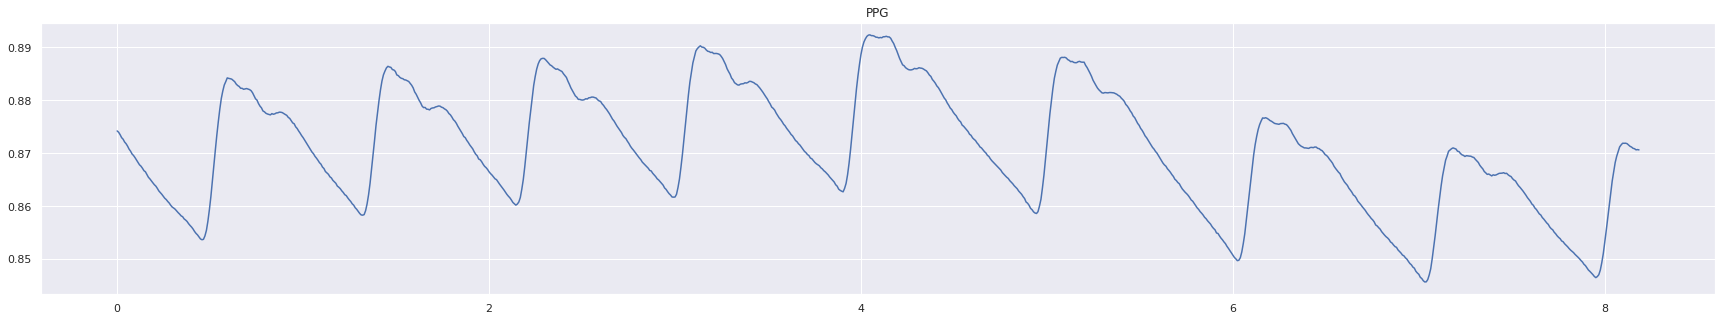

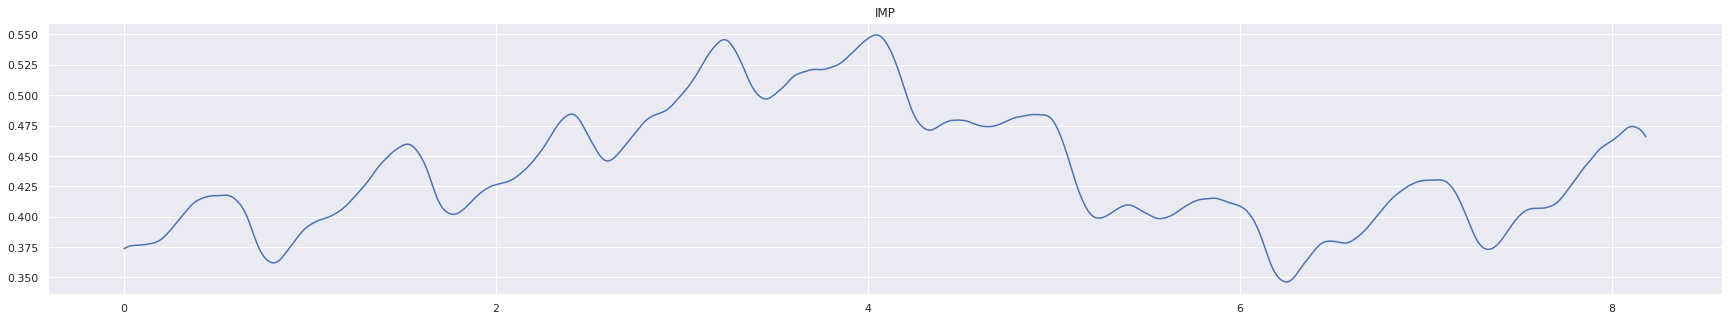

In [ ]:
i = 100
t = np.arange(ppg.shape[1])/125
plt.figure(figsize=(30,5));
plt.plot(t,X_train[i]);
plt.title('PPG')
plt.figure(figsize=(30,5));
plt.plot(t,y_train[i])
plt.title('IMP');

# Transfer Learning of Approximation Model

### Define the model

In [ ]:
def UNetDS64(length, n_channel=1):
    """
        Deeply supervised U-Net with kernels multiples of 64
    
    Arguments:
        length {int} -- length of the input signal
    
    Keyword Arguments:
        n_channel {int} -- number of channels in the output (default: {1})
    
    Returns:
        keras.model -- created model
    """
    
    x = 64

    inputs = Input((length, n_channel))
    conv1 = Conv1D(x,3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(x,3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(x*2,3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(x*2,3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(x*4,3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv1D(x*4,3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    conv4 = Conv1D(x*8,3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv1D(x*8,3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling1D(pool_size=2)(conv4)

    conv5 = Conv1D(x*16, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv1D(x*16, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    level4 = Conv1D(1, 1, name="level4")(conv5)

    up6 = concatenate([UpSampling1D(size=2)(conv5), conv4], axis=2)
    conv6 = Conv1D(x*8, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv1D(x*8, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    level3 = Conv1D(1, 1, name="level3")(conv6)

    up7 = concatenate([UpSampling1D(size=2)(conv6), conv3], axis=2)
    conv7 = Conv1D(x*4, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv1D(x*4, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    level2 = Conv1D(1, 1, name="level2")(conv7)

    up8 = concatenate([UpSampling1D(size=2)(conv7), conv2], axis=2)
    conv8 = Conv1D(x*2, 3, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv1D(x*2, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    level1 = Conv1D(1, 1, name="level1")(conv8)

    up9 = concatenate([UpSampling1D(size=2)(conv8), conv1], axis=2)
    conv9 = Conv1D(x, 3, activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv1D(x, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    out = Conv1D(1, 1, name="out")(conv9)

    model = Model(inputs=[inputs], outputs=[out, level1, level2, level3, level4])
    
    

    return model


### Load the model

In [ ]:
length = 1024                                                           # length of signal
app_model = UNetDS64(length)                                            # creating approximation network
app_model.load_weights(os.path.join('ApproximateNetwork.h5'))           # loading weights

### Freezing some layers for transfer learning

In [ ]:
for i in range(21):

    app_model.layers[i].trainable = False

In [ ]:
for i in range(len(app_model.layers)):
    print(i,app_model.layers[i].trainable)

### Preparing data for Deep Supervision

In [ ]:
def prepareLabel(Y):

	"""
	Prepare label for deep supervised pipeline
	
	Returns:
		dictionary -- dictionary containing the 5 level ground truth outputs of the network
	"""
	
	def approximate(inp,w_len):
		"""
		Downsamples using taking mean over window
		
		Arguments:
			inp {array} -- signal
			w_len {int} -- length of window
		
		Returns:
			array -- downsampled signal
		"""
		
		op = []
		
		for i in range(0,len(inp),w_len):
		
			op.append(np.mean(inp[i:i+w_len]))
			
		return np.array(op)
	
	out = {}
	out['out'] = []
	out['level1'] = []
	out['level2'] = []
	out['level3'] = []
	out['level4'] = []
	
	
	for y in tqdm(Y,desc='Preparing Label for DS'):
	
																	# computing approximations
		cA1 = approximate(np.array(y).reshape(length), 2)
		
		cA2 = approximate(np.array(y).reshape(length), 4)
		
		cA3 = approximate(np.array(y).reshape(length), 8)
		
		cA4 = approximate(np.array(y).reshape(length), 16)
		
		
		
																	# populating the labels for different labels
		out['out'].append(np.array(y.reshape(length,1)))
		out['level1'].append(np.array(cA1.reshape(length//2,1)))
		out['level2'].append(np.array(cA2.reshape(length//4,1)))
		out['level3'].append(np.array(cA3.reshape(length//8,1)))
		out['level4'].append(np.array(cA4.reshape(length//16,1)))
		
	out['out'] = np.array(out['out'])                                # converting to numpy array
	out['level1'] = np.array(out['level1'])
	out['level2'] = np.array(out['level2'])
	out['level3'] = np.array(out['level3'])
	out['level4'] = np.array(out['level4'])
	
	
	return out


In [ ]:
# Preparing Label for Deep Supervision
DS_Y = prepareLabel(y_train)

Preparing Label for DS: 100%|██████████| 2500/2500 [00:14<00:00, 169.51it/s]


### Training the Approximation Model

In [ ]:
app_model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mean_squared_error'], loss_weights=[1., 0.9, 0.8, 0.7, 0.6])

In [ ]:
# Holdout Validation
checkpoint1_ = ModelCheckpoint(os.path.join('models','app_model.h5'), verbose=1, monitor='val_out_loss',save_best_only=True, mode='auto')
app_model.fit(X_train,{'out': DS_Y['out'], 'level1': DS_Y['level1'], 'level2':DS_Y['level2'], 'level3':DS_Y['level3'] , 'level4':DS_Y['level4']},epochs=100,batch_size=256,validation_split=0.2,callbacks=[checkpoint1_],verbose=1)


Epoch 1/100
8/8 [==============================] - 20s 732ms/step - loss: 0.7868 - out_loss: 0.2018 - level1_loss: 0.1931 - level2_loss: 0.1932 - level3_loss: 0.1913 - level4_loss: 0.2044 - out_mean_squared_error: 0.0595 - level1_mean_squared_error: 0.0557 - level2_mean_squared_error: 0.0541 - level3_mean_squared_error: 0.0635 - level4_mean_squared_error: 0.0878 - val_loss: 0.4155 - val_out_loss: 0.1147 - val_level1_loss: 0.1102 - val_level2_loss: 0.0924 - val_level3_loss: 0.1036 - val_level4_loss: 0.0920 - val_out_mean_squared_error: 0.0189 - val_level1_mean_squared_error: 0.0180 - val_level2_mean_squared_error: 0.0162 - val_level3_mean_squared_error: 0.0192 - val_level4_mean_squared_error: 0.0164

Epoch 00001: val_out_loss improved from inf to 0.11468, saving model to models/app_model.h5
Epoch 2/100
8/8 [==============================] - 3s 384ms/step - loss: 0.4949 - out_loss: 0.1386 - level1_loss: 0.1293 - level2_loss: 0.1212 - level3_loss: 0.1097 - level4_loss: 0.1104 - out_mean_s

### Loading the new saved app_model

In [ ]:
length = 1024                                                           # length of signal
app_model = UNetDS64(length)                                            # creating approximation network
app_model.load_weights(os.path.join('models','app_model.h5'))           # loading weights

### 10 Fold validation

In [ ]:
try:                                                        # create directory to save models
      os.makedirs('models')
except:
      pass

try:                                                        # create directory to save training history
    os.makedirs('History')
except:
    pass

In [ ]:
from sklearn.model_selection import KFold
idx = np.arange(0,X_train.shape[0])

In [ ]:
kf = KFold(n_splits=10, random_state=3, shuffle=True)

In [ ]:
for train_index, test_index in kf.split(idx):
  print("TRAIN:", train_index, "TEST:", test_index)

In [ ]:
foldname = 1;
mdlName1 = 'UNetDS64';
for train_index, val_index in kf.split(idx):
  print('----------------')
  print('Training Fold {}'.format(foldname))
  print('----------------')

  Y_train = prepareLabel(y_train[train_index])                                         # prepare labels for training deep supervision
  
  Y_val = prepareLabel(y_train[val_index])                                             # prepare labels for training deep supervision



 # mdl1 = model_dict[mdlName1](length)             # create approximation network

                                                                      # loss = mae, with deep supervision weights
  # mdl1.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mean_squared_error'], loss_weights=[1., 0.9, 0.8, 0.7, 0.6])                                                         


  checkpoint1_ = ModelCheckpoint(os.path.join('models','{}_model1_fold{}.h5'.format(mdlName1,foldname)), verbose=1, monitor='val_out_loss',save_best_only=True, mode='auto')  
                                                                  # train approximation network for 100 epochs
  history1 = app_model.fit(X_train[train_index],{'out': Y_train['out'], 'level1': Y_train['level1'], 'level2':Y_train['level2'], 'level3':Y_train['level3'] , 'level4':Y_train['level4']},epochs=100,batch_size=256,validation_data=(X_train[val_index],{'out': Y_val['out'], 'level1': Y_val['level1'], 'level2':Y_val['level2'], 'level3':Y_val['level3'] , 'level4':Y_val['level4']}),callbacks=[checkpoint1_],verbose=1)

  pickle.dump(history1, open('History/{}_model1_fold{}.p'.format(mdlName1,foldname),'wb'))    # save training history


  app_model = None                                             # garbage collection

  time.sleep(300)                                         # pause execution for a while to free the gpu

In [ ]:
mdlName1 = 'UNetDS64'
for foldname in range(10):

    print('----------------')
    print('Training Fold {}'.format(foldname+1))
    print('----------------')
                                                                                        # loading training data
    # dt = pickle.load(open(os.path.join('data','train{}.p'.format(foldname)),'rb'))
    # X_train = dt['X_train']
    # Y_train = dt['Y_train']
                                                                                        # loading validation data
    # dt = pickle.load(open(os.path.join('data','val{}.p'.format(foldname)),'rb'))
    # X_val = dt['X_val']
    # Y_val = dt['Y_val']

                                                                                        # loading metadata
    # dt = pickle.load(open(os.path.join('data','meta{}.p'.format(foldname)),'rb'))
    # max_ppg = dt['max_ppg']
    # min_ppg = dt['min_ppg']
    # max_abp = dt['max_abp']
    # min_abp = dt['min_abp']


    # Y_train = prepareLabel(Y_train)                                         # prepare labels for training deep supervision
    
    # Y_val = prepareLabel(Y_val)                                             # prepare labels for training deep supervision



    # mdl1 = model_dict[mdlName1](length)             # create approximation network

    #                                                                     # loss = mae, with deep supervision weights
    # mdl1.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mean_squared_error'], loss_weights=[1., 0.9, 0.8, 0.7, 0.6])                                                         


    checkpoint1_ = ModelCheckpoint(os.path.join('models','{}_model1_fold{}.h5'.format(mdlName1,foldname)), verbose=1, monitor='val_out_loss',save_best_only=True, mode='auto')  
                                                                    # train approximation network for 100 epochs
    history1 = app_model.fit(X_train,{'out': DS_Y['out'], 'level1': DS_Y['level1'], 'level2':DS_Y['level2'], 'level3':DS_Y['level3'] , 'level4':DS_Y['level4']},epochs=100,batch_size=256,validation_data=(X_val,{'out': Y_val['out'], 'level1': Y_val['level1'], 'level2':Y_val['level2'], 'level3':Y_val['level3'] , 'level4':Y_val['level4']}),callbacks=[checkpoint1_],verbose=1)

    pickle.dump(history1, open('History/{}_model1_fold{}.p'.format(mdlName1,foldname),'wb'))    # save training history


    mdl1 = None                                             # garbage collection

    time.sleep(300)                                         # pause execution for a while to free the gpu

# Transfer Learning for Refinement Model

### Preparing new data for refinement model

In [ ]:
def prepareDataDS(mdl, X):
	"""
	Prepares data for 2nd stage training in the deep supervised pipeline
	
	Arguments:
		mdl {keras.model} -- keras model
		X {array} -- array being X train or X val
	
	Returns:
		X {array} -- suitable X for 2nd stage training
	"""
	
	X2 = []


	YPs = mdl.predict(X)
	
	for i in tqdm(range(len(X)),desc='Preparing Data for DS'):
		
	   X2.append(np.array(YPs[0][i]))

	X2 = np.array(X2)


	return X2

In [ ]:
X_train2 = prepareDataDS(app_model, X_train)

Preparing Data for DS: 100%|██████████| 2500/2500 [00:00<00:00, 280248.02it/s]


### Defining the model

In [ ]:
def MultiResUNet1D(length, n_channel=1):
    """
       1D MultiResUNet
    
    Arguments:
        length {int} -- length of the input signal
    
    Keyword Arguments:
        n_channel {int} -- number of channels in the output (default: {1})
    
    Returns:
        keras.model -- created model
    """

    def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
        
        kernel = 3

        x = Conv1D(filters, kernel,  padding=padding)(x)
        x = BatchNormalization()(x)

        if(activation == None):
            return x

        x = Activation(activation, name=name)(x)
        return x


    def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
 
        x = UpSampling1D(size=2)(x)        
        x = BatchNormalization()(x)
        
        return x


    def MultiResBlock(U, inp, alpha = 2.5):
        '''
        MultiRes Block
        
        Arguments:
            U {int} -- Number of filters in a corrsponding UNet stage
            inp {keras layer} -- input layer 
        
        Returns:
            [keras layer] -- [output layer]
        '''

        W = alpha * U

        shortcut = inp

        shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                            int(W*0.5), 1, 1, activation=None, padding='same')

        conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                            activation='relu', padding='same')

        conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                            activation='relu', padding='same')

        conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                            activation='relu', padding='same')

        out = concatenate([conv3x3, conv5x5, conv7x7], axis=-1)
        out = BatchNormalization()(out)

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization()(out)

        return out


    def ResPath(filters, length, inp):
        '''
        ResPath
        
        Arguments:
            filters {int} -- [description]
            length {int} -- length of ResPath
            inp {keras layer} -- input layer 
        
        Returns:
            [keras layer] -- [output layer]
        '''


        shortcut = inp
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                            activation=None, padding='same')

        out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization()(out)

        for i in range(length-1):

            shortcut = out
            shortcut = conv2d_bn(shortcut, filters, 1, 1,
                                activation=None, padding='same')

            out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

            out = add([shortcut, out])
            out = Activation('relu')(out)
            out = BatchNormalization()(out)

        return out





    inputs = Input((length, n_channel))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling1D(pool_size=2)(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling1D(pool_size=2)(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling1D(pool_size=2)(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling1D(pool_size=2)(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([UpSampling1D(size=2)(mresblock5), mresblock4], axis=-1)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([UpSampling1D(size=2)(mresblock6), mresblock3], axis=-1)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([UpSampling1D(size=2)(mresblock7), mresblock2], axis=-1)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([UpSampling1D(size=2)(mresblock8), mresblock1], axis=-1)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = Conv1D(1, 1)(mresblock9)
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model


### Loading the model

In [ ]:
ref_model = MultiResUNet1D(length)                                       # creating refinement network
ref_model.load_weights(os.path.join('RefinementNetwork.h5'))             # loading weights

### Training the Refinement Model

In [ ]:
ref_model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [ ]:
checkpoint2_ = ModelCheckpoint(os.path.join('models','ref_model.h5'), verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
ref_model.fit(X_train2,y_train,epochs=100,batch_size=256,validation_split=0.2,callbacks=[checkpoint2_],verbose=1)

Epoch 1/100
8/8 [==============================] - 33s 1s/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0117 - val_mse: 0.0117

Epoch 00001: val_loss improved from inf to 0.01173, saving model to models/ref_model.h5
Epoch 2/100
8/8 [==============================] - 7s 886ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0108 - val_mse: 0.0108

Epoch 00002: val_loss improved from 0.01173 to 0.01083, saving model to models/ref_model.h5
Epoch 3/100
8/8 [==============================] - 7s 887ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0138 - val_mse: 0.0138

Epoch 00003: val_loss did not improve from 0.01083
Epoch 4/100
8/8 [==============================] - 7s 886ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0148 - val_mse: 0.0148

Epoch 00004: val_loss did not improve from 0.01083
Epoch 5/100
8/8 [==============================] - 7s 886ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0131 - val_mse: 0.0131

Epoch 00005: val_loss did not improve from 0.01083
Epoch 6/1

### Loading the new saved ref_model

In [ ]:
length = 1024                                                           # length of signal
ref_model = MultiResUNet1D(length)                                             # creating approximation network
ref_model.load_weights(os.path.join('models','ref_model.h5'))           # loading weights

# Results

### Training result

In [ ]:
train_pred_app = prepareDataDS(app_model, X_train)
train_pred_ref = ref_model.predict(train_pred_app)

Preparing Data for DS: 100%|██████████| 2500/2500 [00:00<00:00, 254416.11it/s]


In [ ]:
from scipy.stats.stats import pearsonr
size = [X_train.shape[0]*X_train.shape[1]]; 
c1 = numpy.corrcoef(np.reshape(y_train,size),np.reshape(train_pred_app,size))
c2 = numpy.corrcoef(np.reshape(train_pred_ref,size),np.reshape(train_pred_app,size))
c3 = numpy.corrcoef(np.reshape(y_train,size),np.reshape(train_pred_ref,size))
# c = pearsonr(np.reshape(y_test,[X_test.shape[0]*X_test.shape[1]]),np.reshape(temp2,[X_test.shape[0]*X_test.shape[1]]))
print("Approximation vs GT: ",c1[0,1])
print("Approximation vs Refinement: ",c2[0,1])
print("Refinement vs GT: ",c3[0,1])

Approximation vs GT:  0.4753835874118432
Approximation vs Refinement:  0.767717001392546
Refinement vs GT:  0.6307203322682337


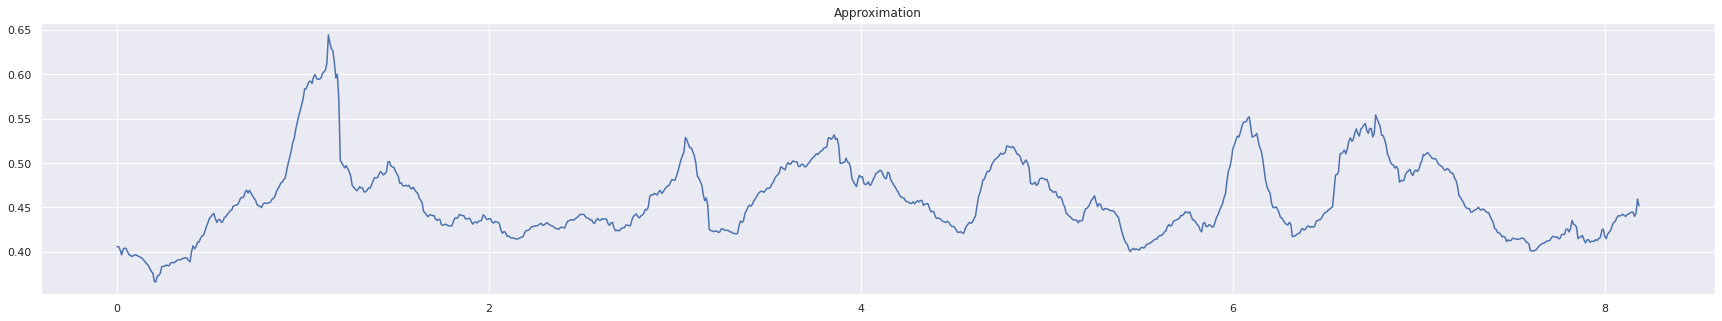

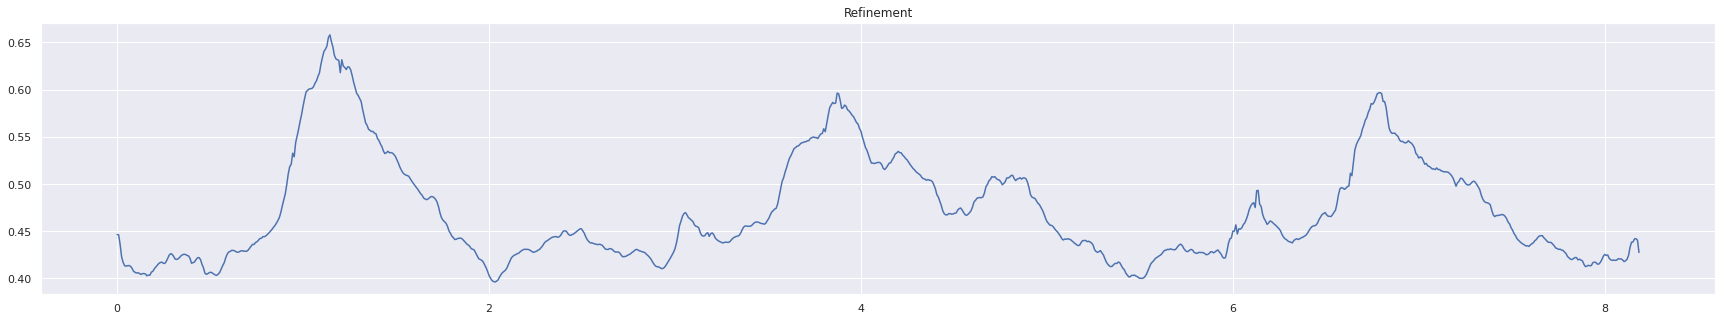

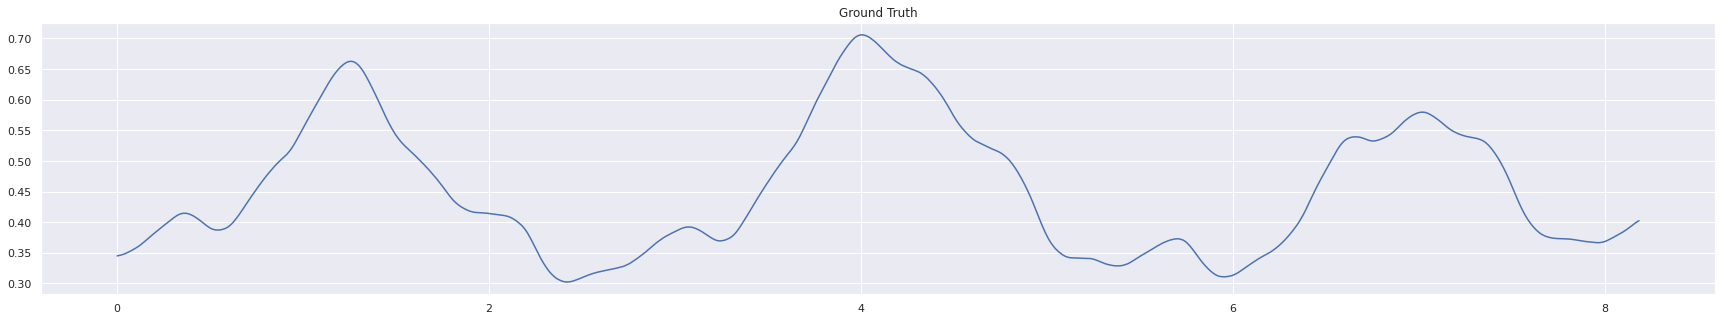

In [ ]:
i = 5
plt.figure(figsize=(30,5));
plt.plot(t,train_pred_app[i])
plt.title('Approximation')
plt.figure(figsize=(30,5));
plt.plot(t,train_pred_ref[i])
plt.title('Refinement')
plt.figure(figsize=(30,5));
plt.plot(t,y_train[i])
plt.title('Ground Truth');

### Prediction

In [ ]:
test_pred_app = prepareDataDS(app_model, X_test)
test_pred_ref = ref_model.predict(test_pred_app)

Preparing Data for DS: 100%|██████████| 511/511 [00:00<00:00, 122979.65it/s]


In [ ]:
print(pearsonr(np.reshape(y_test,[X_test.shape[0],X_test.shape[1]]),np.reshape(temp2,[X_test.shape[0],X_test.shape[1]])))

In [ ]:
from scipy.stats.stats import pearsonr
size = [X_test.shape[0]*X_test.shape[1]]; 
c1 = numpy.corrcoef(np.reshape(y_test,size),np.reshape(test_pred_app,size))
c2 = numpy.corrcoef(np.reshape(test_pred_ref,size),np.reshape(test_pred_app,size))
c3 = numpy.corrcoef(np.reshape(y_test,size),np.reshape(test_pred_ref,size))
# c = pearsonr(np.reshape(y_test,[X_test.shape[0]*X_test.shape[1]]),np.reshape(temp2,[X_test.shape[0]*X_test.shape[1]]))
print("Approximation vs GT: ",c1[0,1])
print("Approximation vs Refinement: ",c2[0,1])
print("Refinement vs GT: ",c3[0,1])

Approximation vs GT:  0.28305537766264144
Approximation vs Refinement:  0.7370713734420229
Refinement vs GT:  0.31302200138944625


In [ ]:
rms = mean_squared_error(np.reshape(y_test,[X_test.shape[0],X_test.shape[1]]),np.reshape(temp2,[X_test.shape[0],X_test.shape[1]]), squared=False)
rms

0.24759358121190828

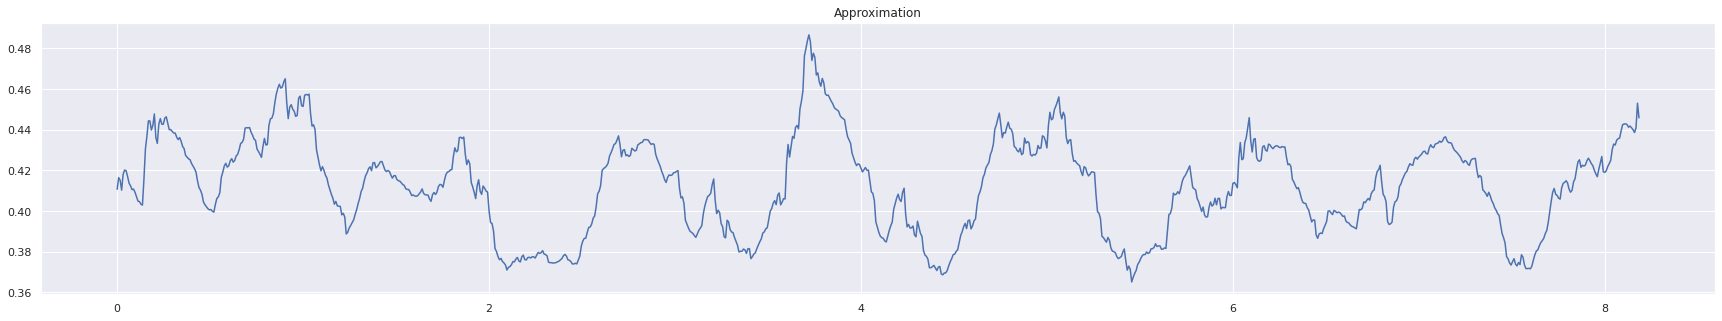

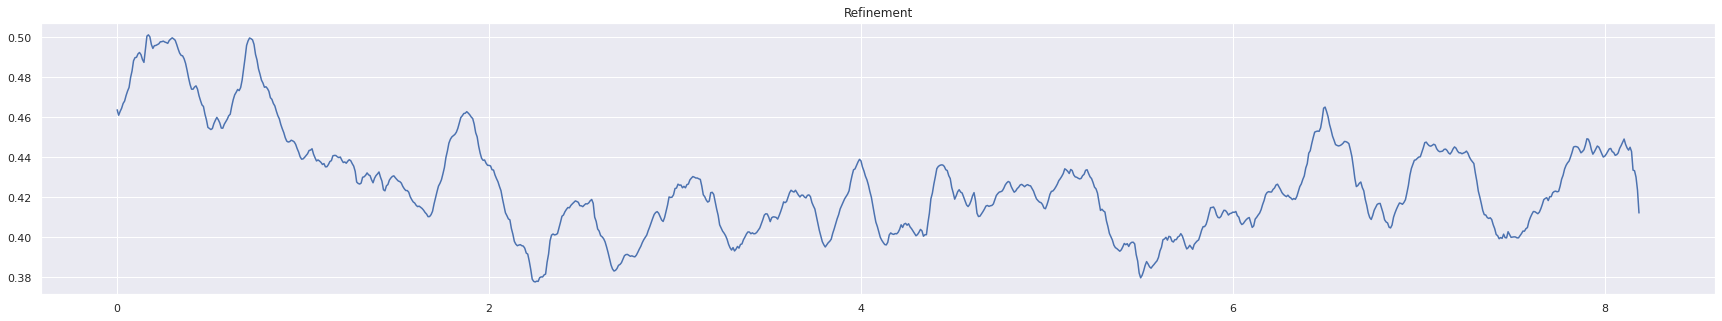

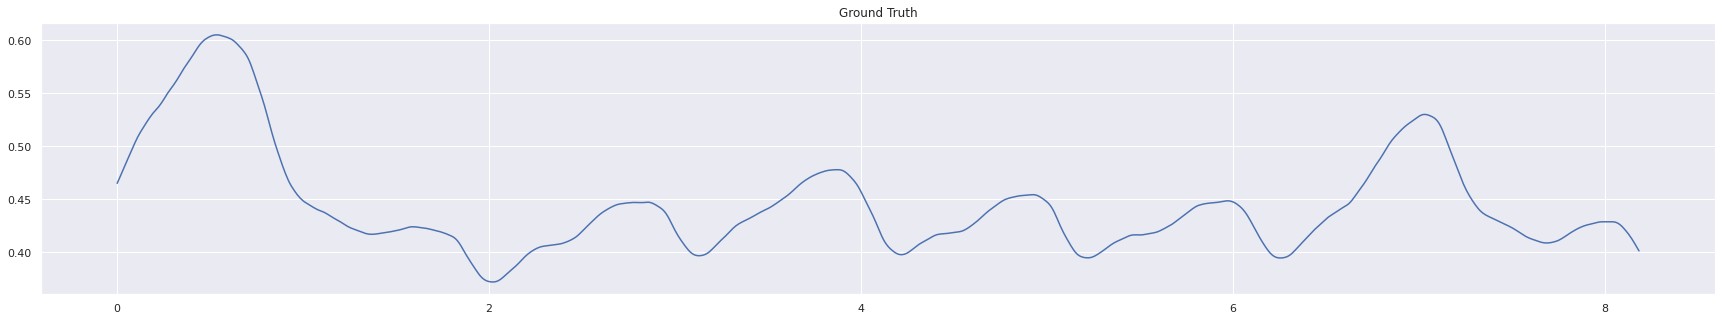

In [ ]:
i = 50
plt.figure(figsize=(30,5));
plt.plot(t,test_pred_app[i])
plt.title('Approximation')
plt.figure(figsize=(30,5));
plt.plot(t,test_pred_ref[i])
plt.title('Refinement')
plt.figure(figsize=(30,5));
plt.plot(t,y_test[i])
plt.title('Ground Truth');